# Sales Conversion Optimization

Link to kaggle challenge:

*https://www.kaggle.com/datasets/loveall/clicks-conversion-tracking?resource=download*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Reading Data

In [2]:
data = pd.read_csv('../data/KAG_conversion_data.csv')

In [3]:
data.shape

(1143, 11)

### Exploraroty Analysis

In [4]:
## amount of unique ads
len(data.ad_id.unique())

1143

In [5]:
## amount of company campaigns
len(data.xyz_campaign_id.unique())

3

In [6]:
## amount of unique fb ad campaigns
len(data.fb_campaign_id.unique())

691

In [7]:
## amount of unique ads per company campaign
data.groupby("xyz_campaign_id")["ad_id"].nunique()

xyz_campaign_id
916      54
936     464
1178    625
Name: ad_id, dtype: int64

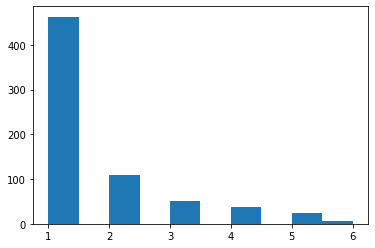

In [8]:
## amount of nr of ads per fb campaign, visualized
tmp = data.groupby("fb_campaign_id")["ad_id"].nunique()
plt.hist(tmp);

##### Notes:

1. 3 campaigns internally in the company
2. 691 registered campaigns on fb
3. 1143 individual ads in total
4. unevenly distributed amounts of individual ads per campaign (from 1 to 6)

#### Average amount spent per ad

In [9]:
avg = round(data.Spent.median(),2)

print(f'Average amount (median, due to skew) spent per ad: {avg}')

Average amount (median, due to skew) spent per ad: 12.37


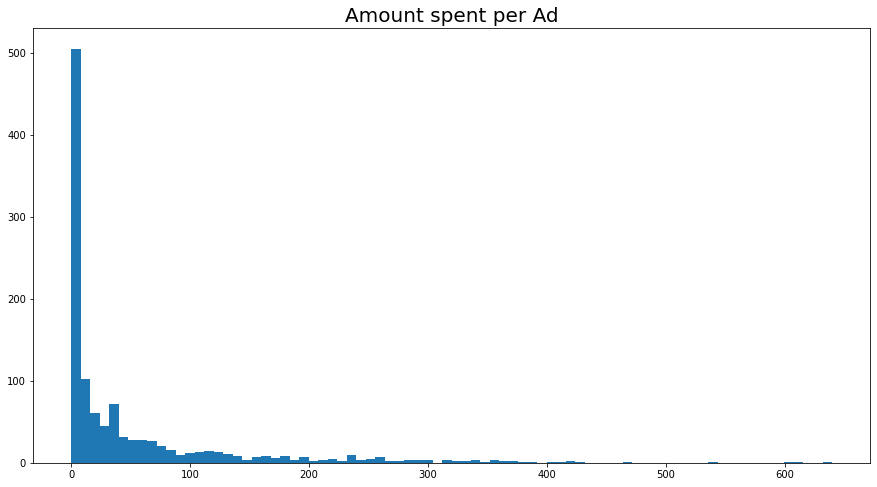

In [10]:
plt.figure(figsize=(15,8))
plt.hist(data.Spent, bins=80)

plt.title("Amount spent per Ad", size=20);

#### Number of conversions

/Users/garritwilson/.pyenv/versions/3.8.12/envs/li-monitoring/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


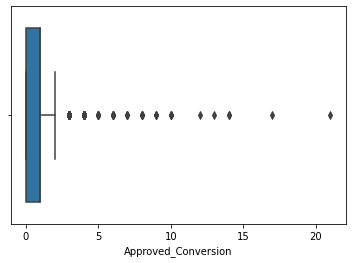

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(data.Approved_Conversion);

### Data Cleaning

In [12]:
data.dtypes

ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object

In [13]:
data.isnull().sum()

ad_id                  0
xyz_campaign_id        0
fb_campaign_id         0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64

(Data appears to be clean)

## Feature Engineering

1. CTR (click-through-rate)
2. Conversion Rate
3. Cost per Click
4. Cost per Conversion

In [14]:
data.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [15]:
## calculating CTR
data["CTR (%)"] = (data["Clicks"] / data["Impressions"]) * 100

In [16]:
## calculating Conversion Rate

mask = (data["Clicks"] != 0)
data_valid = data[mask]

data["CR (%)"] = 0

data.loc[mask, "CR (%)"] = (data_valid["Approved_Conversion"] / data_valid["Clicks"]) * 100

*https://stackoverflow.com/questions/33769860/pandas-apply-but-only-for-rows-where-a-condition-is-met*

In [17]:
## calculating Cost per Click

mask = (data["Clicks"] != 0)
data_valid = data[mask]

data["CpC"] = 0

data.loc[mask, "CpC"] = data["Clicks"] / data["Spent"]

In [18]:
## calculating cost per conversion

mask = (data["Spent"] != 0) & (data["Approved_Conversion"] != 0)
data_valid = data[mask]

data["CpConv"] = 0

data.loc[mask, "CpConv"] = data["Spent"] / data["Approved_Conversion"]

## Q1 - Is there a relationship between Ad Spend and Conversion?

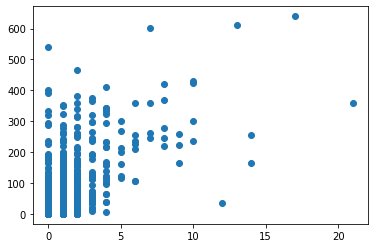

In [19]:
plt.scatter(x= data.Approved_Conversion, y= data.Spent)

<AxesSubplot:xlabel='Approved_Conversion', ylabel='Spent'>

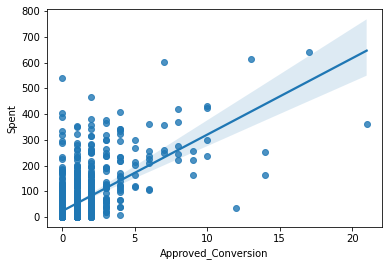

In [20]:
sns.regplot(x = "Approved_Conversion",
            y= "Spent",
           data= data)

# Data Preparation for Modeling

In [34]:
data.head(2)

,ad_id,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR (%),CR (%),CpC,CpConv
0,708746,campaign_a,30-34,M,15,7350,1,1.43,2,1,0.013605,100.0,0.699301,1.43
1,708749,campaign_a,30-34,M,16,17861,2,1.82,2,0,0.011198,0.0,1.098901,0.00


In [22]:
data.drop("fb_campaign_id", axis=1, inplace= True)

In [33]:
data["xyz_campaign_id"].replace({916:"campaign_a" ,936:"campaign_b" ,1178:"campaign_c"}, inplace=True)

In [39]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for col in ["xyz_campaign_id", "age", "gender"]:
    
    encoder.fit(data[col])
    
    data[col] = encoder.transform(data[col])
    
    print(col, data[col].nunique())

xyz_campaign_id 3
age 4
gender 2


**(Missing: Feature Scaling!)**

# Clustering

In [53]:
from sklearn.cluster import KMeans

In [54]:
km = KMeans(n_clusters= 4)

In [56]:
km.fit(data.drop(["Total_Conversion", "Approved_Conversion"], axis= 1))

KMeans(n_clusters=4)

In [57]:
data["Cluster"] = km.labels_

In [58]:
data.head()

,ad_id,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR (%),CR (%),CpC,CpConv,Cluster
0,708746,0,0,1,15,7350,1,1.43,2,1,0.013605,100.0,0.699301,1.43,0
1,708749,0,0,1,16,17861,2,1.82,2,0,0.011198,0.0,1.098901,0.00,0
2,708771,0,0,1,20,693,0,0.00,1,0,0.000000,0.0,0.000000,0.00,0
3,708815,0,0,1,28,4259,1,1.25,1,0,0.023480,0.0,0.800000,0.00,0
4,708818,0,0,1,28,4133,1,1.29,1,1,0.024195,100.0,0.775194,1.29,0


# Regression

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [61]:
forest = RandomForestRegressor(n_estimators= 100)

In [67]:
X = data.drop(["ad_id","Approved_Conversion", "Total_Conversion"], axis= 1)
y = data["Approved_Conversion"]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size= 0.33)

In [70]:
forest.fit(X_train, y_train)

RandomForestRegressor()

### Evaluation

In [73]:
from sklearn.metrics import mean_squared_error

In [74]:
y_pred = forest.predict(X_test)

In [75]:
mse = mean_squared_error(y_test, y_pred)

In [76]:
mse

0.6813240740740739

# Sandbox